# DATA PREPROCESSING

In [3]:
import pandas as pd
import numpy as np

In [2]:
export = pd.read_csv("export.csv")

In [3]:
export['new_session'] = export['account_id'].ne(export['account_id'].shift()).cumsum()

In [4]:
mask_data = export[['ed_id', 'new_session']]

In [5]:
def process_journey_to_mask(group):
    """
    Creates a mask for each journey according to the specified criteria:
    - If ed_id = 29 is present, the mask includes rows up to and including the first occurrence of ed_id = 29.
    - If ed_id = 29 is not present, the mask includes all rows.
    
    Returns a boolean mask that can be applied to a DataFrame.
    """
    # Initialize a mask with all False
    mask = pd.Series(False, index=group.index)
    
    if 29 in group['ed_id'].values:
        # Find the index of the first occurrence of ed_id = 29
        first_occurrence_index = group[group['ed_id'] == 29].index[0]
        # Update the mask to True for all rows up to and including the first occurrence of ed_id = 29
        mask.loc[:first_occurrence_index] = True
    else:
        # If ed_id = 29 is not present, all rows are included
        mask[:] = True
    
    return mask

In [6]:
processed_journeys_by_session = [process_journey_to_mask(group) for _, group in mask_data.groupby('new_session')]

In [12]:
activation_mask = pd.concat(processed_journeys_by_session)

In [4]:
up_to_activation = export[activation_mask]

NameError: name 'export' is not defined

In [3]:
up_to_activation = pd.read_csv('up_to_activation.csv')

In [5]:
sessions_with_29 = up_to_activation[up_to_activation['ed_id'] == 29]['new_session'].unique()

In [6]:
up_to_activation['has_29'] = up_to_activation['ed_id'] == 29

In [7]:
up_to_activation['flag_after_29'] = up_to_activation.groupby('account_id')['has_29'].cumsum().shift(fill_value=0) > 0

In [8]:
up_to_activation = up_to_activation[~up_to_activation['flag_after_29']]

In [1]:
up_to_activation.to_csv('up_to_activation.csv', index = False)

NameError: name 'up_to_activation' is not defined

In [6]:
up_to_act = up_to_activation[["new_session","ed_id"]].copy()
# select customer/account/ed_id, count each observation
up_to_act["count"] = up_to_act.groupby(by = ["new_session","ed_id"])["ed_id"].transform("count")
# groups are duplicated, so remove duplicates
up_to_act = up_to_act.drop_duplicates()

In [7]:
up_to_act = up_to_act.pivot(index = ["new_session"], columns="ed_id", values="count").fillna(0)

In [8]:
up_to_act['activated'] = [1 if item == 1 else 0 for item in up_to_act[29]]

In [9]:
up_to_act.to_csv('up_to_act.csv', index = False)

In [508]:
grouped_lists = up_to_activation.groupby('new_session')['ed_id'].apply(list).reset_index()

In [509]:
grouped_lists.to_csv('GroupedLists.csv', index = False)

# SOME EDA

In [83]:
prop_activated = round(up_to_act['activated'].sum() / len(up_to_act['activated']) * 100, 3)

In [84]:
print("Proportion of activated accounts:", prop_activated, "%")

Aroportion of activated accounts: 23.392 %


## Frequency

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [19]:
X = up_to_act.drop(columns = [29, 'activated'])
Y = up_to_act[['activated']].values.flatten()

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
clf = DecisionTreeClassifier(random_state=42, class_weight = 'balanced')

In [22]:
clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

   Feature  Importance
6        7      2.0924
20      21      1.2075
3        4      1.1833
4        5      1.1095
18      19      0.7701
0        1      0.6960
10      11      0.5528
11      12      0.5351
5        6      0.4449
1        2      0.4111
23      24      0.3740
2        3      0.2404
17      18      0.1147
21      22      0.0858
14      15      0.0631
12      13      0.0539
22      23      0.0294
25      28      0.0199
7        8      0.0132
19      20      0.0010
15      16      0.0009
13      14      0.0008
9       10      0.0002
24      27      0.0001
16      17      0.0000
8        9      0.0000


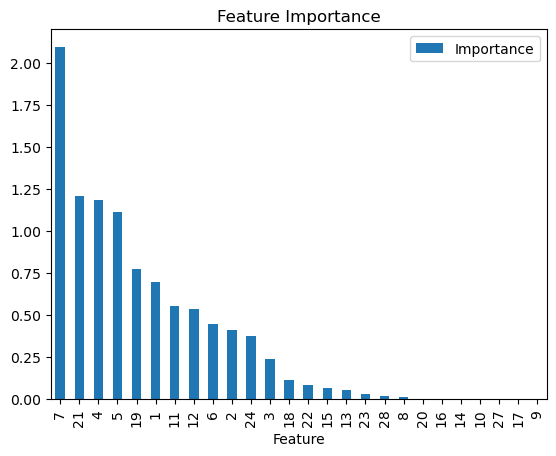

In [23]:
pd.set_option('display.float_format', '{:.4f}'.format)

# Extracting feature importance
feature_importance = clf.feature_importances_ * 10

# Creating a DataFrame for better visualization
features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sorting the DataFrame by importance in descending order
features = features.sort_values(by='Importance', ascending=False)

# Displaying feature importance
print(features)

# Optionally, you can also plot the feature importances
features.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance')
plt.show()

In [26]:
y_pred_clf = clf.predict(X_test)
accuracy_clf = accuracy_score(Y_test, y_pred_clf)
precision_clf = precision_score(Y_test, y_pred_clf)
recall_clf = recall_score(Y_test, y_pred_clf)

print(f"Precision: {precision_clf:.4f}")
print(f"Recall: {recall_clf:.4f}")
print(f'Accuracy: {accuracy_clf:.4f}')

Precision: 0.5915
Recall: 0.6334
Accuracy: 0.8120


## Existence

In [27]:
existence = up_to_act.applymap(lambda x: 1 if x > 1 else x)

In [29]:
X = existence.drop(columns = [29, 'activated'])
Y = existence[['activated']].values.flatten()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [30]:
clf_existence = DecisionTreeClassifier(random_state=42, class_weight = 'balanced')

In [31]:
clf_existence.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

   Feature  Importance
6        7      4.2597
20      21      1.7822
11      12      0.9948
4        5      0.9290
1        2      0.4421
0        1      0.2942
3        4      0.2241
17      18      0.2224
18      19      0.1999
14      15      0.1674
5        6      0.0965
10      11      0.0690
2        3      0.0658
12      13      0.0622
23      24      0.0578
21      22      0.0412
25      28      0.0398
7        8      0.0294
22      23      0.0168
13      14      0.0019
15      16      0.0017
19      20      0.0014
9       10      0.0006
24      27      0.0001
8        9      0.0000
16      17      0.0000


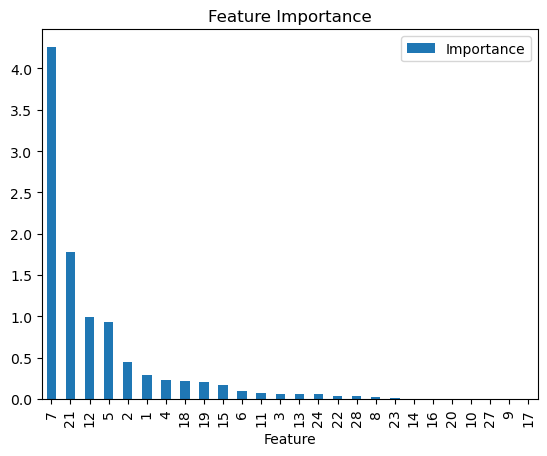

In [32]:
# Extracting feature importance
feature_importance = clf_existence.feature_importances_ * 10

# Creating a DataFrame for better visualization
features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sorting the DataFrame by importance in descending order
features = features.sort_values(by='Importance', ascending=False)

# Displaying feature importance
print(features)

# Optionally, you can also plot the feature importances
features.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance')
plt.show()

In [33]:
y_pred_clf_existence = clf_existence.predict(X_test)
accuracy_clf_existence = accuracy_score(Y_test, y_pred_clf_existence)
precision_clf_existence = precision_score(Y_test, y_pred_clf_existence)
recall_clf_existence = recall_score(Y_test, y_pred_clf_existence)

print(f'Precision: {precision_clf_existence:.4f}')
print(f'Recall: {recall_clf_existence:.4f}')
print(f'Accuracy: {accuracy_clf_existence:.4f}')

Precision: 0.5374
Recall: 0.7156
Accuracy: 0.7894


# RANDOM FOREST

## Frequency

In [ ]:
up_to_act = pd.read_csv('up_to_act.csv')

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [144]:
X = up_to_act.drop(columns = [29, 'activated'])
Y = up_to_act['activated'].values.flatten()

In [145]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [146]:
X_train

ed_id,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,27,28
new_session,,,,,,,,,,,,,,,,,,,,,
1315635,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1334369,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1171417,5.0,0.0,0.0,271.0,12.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1732660,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1301800,9.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,11.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262515,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1433041,3.0,1.0,1.0,23.0,10.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133638,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
rf_clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced', max_depth = 30, min_samples_leaf = 100) 

In [148]:
rf_clf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=100, random_state=42)

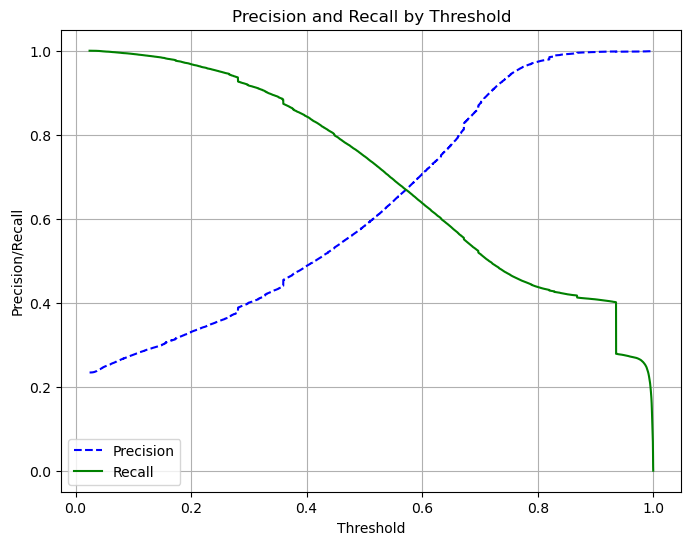

In [149]:
probabilities_test_rf = rf_clf.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(Y_test, probabilities_test)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall by Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [155]:
probabilities_train_rf = rf_clf.predict_proba(X_train)[:, 1]

predictions_train_rf = (probabilities_train_rf >= 0.58).astype(int)
accuracy_rf = accuracy_score(Y_train, predictions_train_rf)
precision_rf = precision_score(Y_train, predictions_train_rf)
recall_rf = recall_score(Y_train, predictions_train_rf)

print(f"Training Precision: {precision_rf:.4f}")
print(f"Training Recall: {recall_rf:.4f}")
print(f'Training Accuracy: {accuracy_rf:.4f}')

Training Precision: 0.6852
Training Recall: 0.6676
Training Accuracy: 0.8505


In [157]:
probabilities_test_rf = rf_clf.predict_proba(X_test)[:, 1]

predictions_test_rf = (probabilities_test_rf >= 0.58).astype(int)
accuracy_rf = accuracy_score(Y_test, predictions_test_rf)
precision_rf = precision_score(Y_test, predictions_test_rf)
recall_rf = recall_score(Y_test, predictions_test_rf)

print(f"Testing Precision: {precision_rf:.4f}")
print(f"Testing Recall: {recall_rf:.4f}")
print(f'Testing Accuracy: {accuracy_rf:.4f}')

Testing Precision: 0.6798
Testing Recall: 0.6604
Testing Accuracy: 0.8478


   Feature  Importance
6        7    2.191568
20      21    1.564074
7        8    1.267741
11      12    1.160599
5        6    0.715064
0        1    0.609459
10      11    0.436904
1        2    0.418685
18      19    0.330713
4        5    0.329635
3        4    0.217935
17      18    0.205172
2        3    0.165330
14      15    0.124698
23      24    0.094200
21      22    0.059038
12      13    0.052426
25      28    0.033099
22      23    0.017645
15      16    0.002113
13      14    0.001705
19      20    0.001481
9       10    0.000612
24      27    0.000074
8        9    0.000015
16      17    0.000015


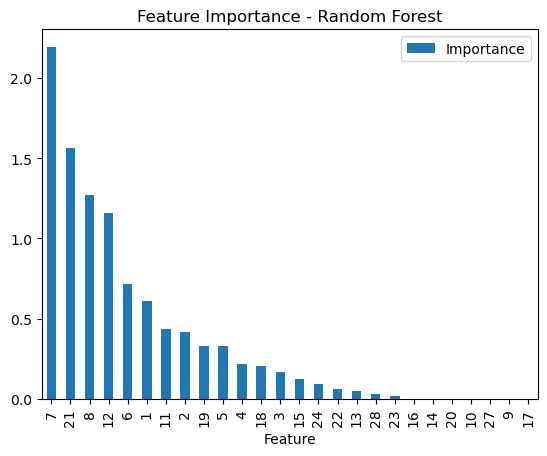

In [152]:
rf_clf.feature_importances_ * 10

features_rf = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance_rf})
features_rf = features_rf.sort_values(by='Importance', ascending=False)

print(features_rf)

features_rf.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance - Random Forest')
plt.show()

## Existence

In [178]:
existence = up_to_act.applymap(lambda x: 1 if x > 1 else x)

In [179]:
X = existence.drop(columns = [29, 'activated'])
Y = existence['activated'].values.flatten()

In [180]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [192]:
rf_clf_existence = RandomForestClassifier(random_state = 42, class_weight = 'balanced', max_depth = 100)

In [193]:
rf_clf_existence.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=100, random_state=42)

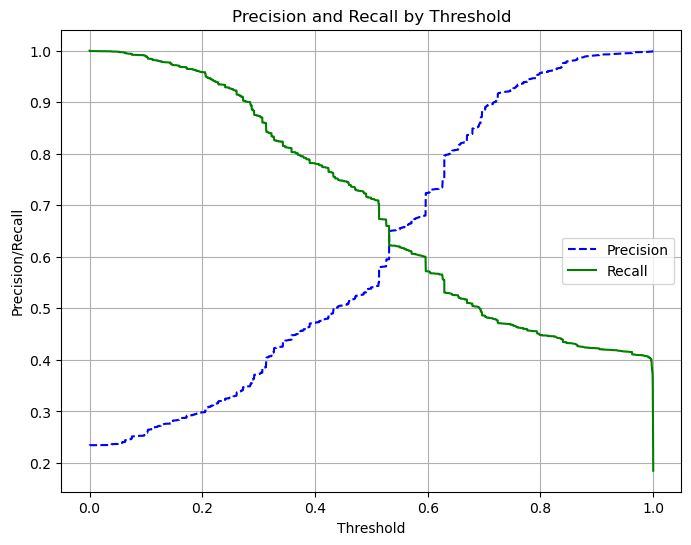

In [194]:
probabilities_test_rf_exist = rf_clf_existence.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(Y_test, probabilities_test_rf_exist)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall by Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [195]:
probabilities_train_rf_exist = rf_clf_existence.predict_proba(X_train)[:, 1]

predictions_train_rf_exist = (probabilities_train_rf_exist >= 0.52).astype(int)
accuracy_rf = accuracy_score(Y_train, predictions_train_rf_exist)
precision_rf = precision_score(Y_train, predictions_train_rf_exist)
recall_rf = recall_score(Y_train, predictions_train_rf_exist)

print(f"Training Precision: {precision_rf:.4f}")
print(f"Training Recall: {recall_rf:.4f}")
print(f'Training Accuracy: {accuracy_rf:.4f}')

Training Precision: 0.5875
Training Recall: 0.6811
Training Accuracy: 0.8135


In [196]:
probabilities_test_rf_exist = rf_clf.predict_proba(X_test)[:, 1]

predictions_test_rf_exist = (probabilities_test_rf_exist >= 0.52).astype(int)
accuracy_rf = accuracy_score(Y_test, predictions_test_rf_exist)
precision_rf = precision_score(Y_test, predictions_test_rf_exist)
recall_rf = recall_score(Y_test, predictions_test_rf_exist)

print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f'Accuracy: {accuracy_rf:.4f}')

Precision: 0.4609
Recall: 0.6894
Accuracy: 0.7388


   Feature  Importance
6        7    2.191568
20      21    1.564074
7        8    1.267741
11      12    1.160599
5        6    0.715064
0        1    0.609459
10      11    0.436904
1        2    0.418685
18      19    0.330713
4        5    0.329635
3        4    0.217935
17      18    0.205172
2        3    0.165330
14      15    0.124698
23      24    0.094200
21      22    0.059038
12      13    0.052426
25      28    0.033099
22      23    0.017645
15      16    0.002113
13      14    0.001705
19      20    0.001481
9       10    0.000612
24      27    0.000074
8        9    0.000015
16      17    0.000015


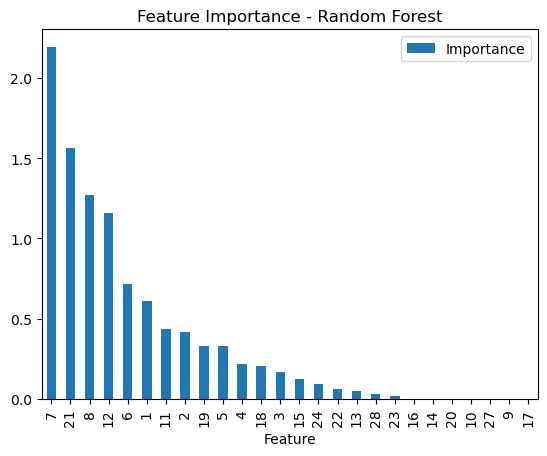

In [197]:
feature_importance_rf = rf_clf_existence.feature_importances_ * 10

features_rf = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance_rf})
features_rf = features_rf.sort_values(by='Importance', ascending=False)

print(features_rf)

features_rf.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance - Random Forest')
plt.show()

## Frequency

In [158]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import plot_importance
from scipy.stats import randint, uniform

In [159]:
X = up_to_act.drop(columns = [29, 'activated'])
Y = up_to_act['activated'].values.flatten()

In [160]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [161]:
sum_negatives = sum(Y_train == 0)
sum_positives = sum(Y_train == 1)
scale_pos_weight = sum_negatives / sum_positives

In [162]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, max_depth = 10, min_samples_leaf = 500, learning_rate = 0.01)

In [163]:
xgb_model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, min_samples_leaf=500,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=None, n_jobs=None, num_parallel_tree=None, ...)

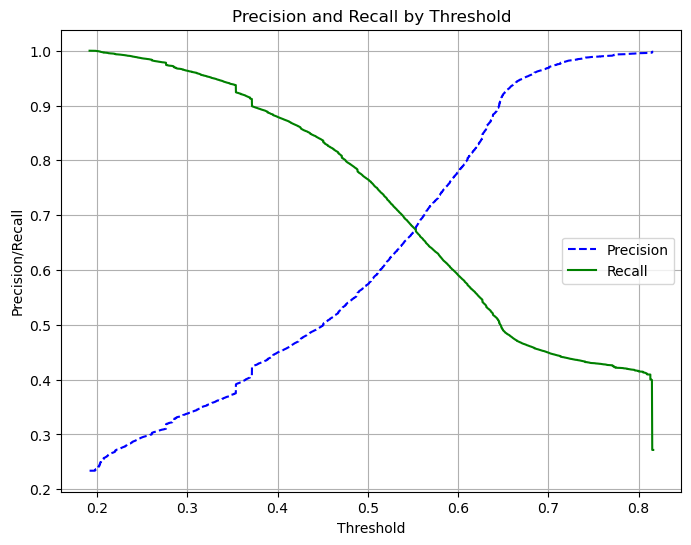

In [164]:
probabilities_test_xgb = xgb_model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(Y_test, probabilities_test_xgb)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall by Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [166]:
probabilities_train_xgb = xgb_model.predict_proba(X_train)[:, 1]

predictions_train_xgb = (probabilities_train_xgb >= 0.55).astype(int)

accuracy = accuracy_score(Y_train, predictions_train_xgb)
precision = precision_score(Y_train, predictions_train_xgb)
recall = recall_score(Y_train, predictions_train_xgb)

print(f"Training Precision: {precision}")
print(f"Training Recall: {recall}")
print(f"Training Accuracy: {accuracy}")

Training Precision: 0.6727450950360693
Training Recall: 0.6850055518820256
Training Accuracy: 0.8483587059942912


In [165]:
predictions_test_xgb = (probabilities_test_xgb >= 0.55).astype(int)

accuracy = accuracy_score(Y_test, predictions_test_xgb)
precision = precision_score(Y_test, predictions_test_xgb)
recall = recall_score(Y_test, predictions_test_xgb)

print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing Accuracy: {accuracy}")

Testing Precision: 0.6681126116716025
Testing Recall: 0.6785861384655708
Testing Accuracy: 0.8460133030963701


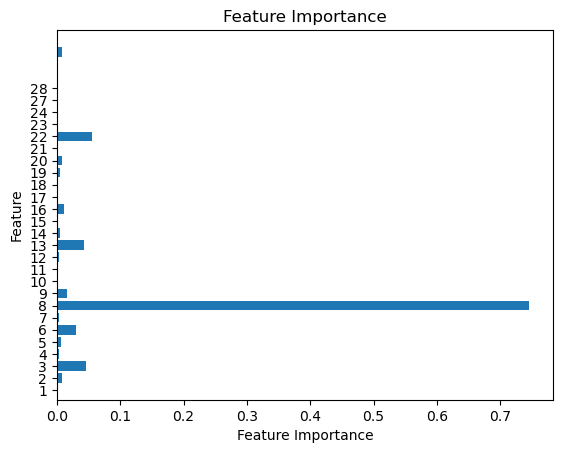

In [167]:
importance = xgb_model.feature_importances_
feature_names = X_train.columns  # Adjust this if your features are indexed differently

# Create a bar plot
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.yticks(ticks=range(len(feature_names)), labels=feature_names)
plt.show()

## Existence

In [31]:
import xgboost as xgb
from pdpbox import pdp

In [32]:
existence = up_to_act.applymap(lambda x: 1 if x > 1 else x)

In [33]:
X = existence.drop(columns = [29, 'activated'])
Y = existence['activated'].values.flatten()

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [65]:
sum_negatives = sum(Y_train == 0)
sum_positives = sum(Y_train == 1)
scale_pos_weight = sum_negatives / sum_positives

In [30]:
xgb_existence = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight = scale_pos_weight, learning_rate = 0.05)
xgb_existence.fit(X_train, Y_train)

NameError: name 'xgb' is not defined

In [73]:
xgb_exist_pred = xgb_existence.predict(X_test)

accuracy = accuracy_score(Y_test, xgb_exist_pred)
precision = precision_score(Y_test, xgb_exist_pred)
recall = recall_score(Y_test, xgb_exist_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Precision: 0.5390425372012626
Recall: 0.7161667977184508
Accuracy: 0.790416400342063


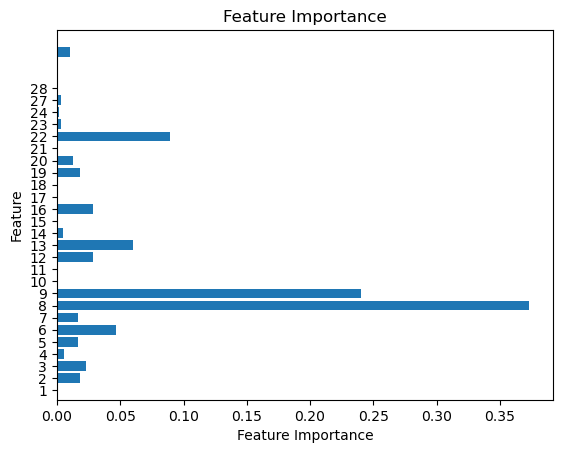

In [75]:
importance = xgb_existence.feature_importances_
feature_names = X_train.columns  # Adjust this if your features are indexed differently

# Create a bar plot
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.yticks(ticks=range(len(feature_names)), labels=feature_names)

plt.show()

## STACKED XGBOOST AND RANDOM FOREST

In [168]:
from sklearn.linear_model import LogisticRegression

In [169]:
predictions_train_rf
predictions_test_rf

predictions_train_xgb
predictions_test_xgb

array([0, 0, 0, ..., 0, 0, 0])

In [170]:
X_train_stacked = np.column_stack((predictions_train_rf, predictions_train_xgb))
X_test_stacked = np.column_stack((predictions_test_rf, predictions_test_xgb))

In [173]:
stacked_model = LogisticRegression()
stacked_model.fit(X_train_stacked, Y_train)

LogisticRegression()

In [177]:
stacked_pred = stacked_model.predict(X_test_stacked)

# Evaluate the model
accuracy = accuracy_score(Y_test, stacked_pred)
precision = precision_score(Y_test, stacked_pred)
recall = recall_score(Y_test, stacked_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.7061
Recall: 0.6414
Accuracy: 0.8537


# Logistic Regression

In [305]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [336]:
existence = up_to_act.applymap(lambda x: 1 if x > 1 else x)

In [489]:
X = existence.drop(columns = [29, 12, 15, 'activated'])
Y = existence['activated'].values.flatten()

In [490]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [491]:
X_train

ed_id,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,27,28
new_session,,,,,,,,,,,,,,,,,,,,,
1608908,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1502283,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244914,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158313,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
204178,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262515,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1433041,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133638,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [492]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [493]:
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C= 0.1, class_weight = 'balanced')
model_l1.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [494]:
probabilities_train = model_l1.predict_proba(X_train_scaled)[:,1]
probabilities_test = model_l1.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probabilities_test)

In [495]:
# Calculate F1 scores from the precision and recall
F1_scores = 2 * (precision * recall) / (precision + recall)

# Find the index of the maximum F1 score
max_f1_index = F1_scores.argmax()

# Find the best threshold that maximizes the F1 score
best_threshold = thresholds[max_f1_index]

print(f"Best Threshold: {best_threshold}")
print(f"Precision at Best Threshold: {precision[max_f1_index]}")
print(f"Recall at Best Threshold: {recall[max_f1_index]}")
print(f"Max F1 Score: {F1_scores[max_f1_index]}")

Best Threshold: 0.5820415327522912
Precision at Best Threshold: 0.6036987562952699
Recall at Best Threshold: 0.6059561285164643
Max F1 Score: 0.6048253361318344


In [496]:
predictions_train_l1 = (probabilities_train >= best_threshold).astype(int)
predictions_test_l1 = (probabilities_test >= best_threshold).astype(int)

In [497]:
accuracy_l1_train = accuracy_score(y_train, predictions_train_l1)
precision_l1_train = precision_score(y_train, predictions_train_l1)
recall_l1_train = recall_score(y_train, predictions_train_l1)
F_score = 2 * (precision_l1_train * recall_l1_train) / (precision_l1_train + recall_l1_train)

print(f"Train F Score: {F_score:.4f}")
print(f"Train Accuracy: {accuracy_l1_train:.4f}")

Train F Score: 0.6078
Train Accuracy: 0.8162


In [498]:
accuracy_l1_test = accuracy_score(y_test, predictions_test_l1)
precision_l1_test = precision_score(y_test, predictions_test_l1)
recall_l1_test = recall_score(y_test, predictions_test_l1)
F_score = 2 * (precision_l1_test * recall_l1_test) / (precision_l1_test + recall_l1_test)

print(f"Test F score: {F_score:.4f}")
print(f"Accuracy: {accuracy_l1_test:.4f}")

Test F score: 0.6048
Accuracy: 0.8150


In [505]:
feature_names = X_train.columns.tolist()
coefficients = model_l1.coef_[0]

# Pairing each feature name with its coefficient
feature_importances = zip(feature_names, coefficients)

# Sorting the features by absolute value of their coefficient for better readability
sorted_feature_importances = sorted(feature_importances, key=lambda x: abs(x[1]), reverse=True)

# Nicely printing each feature with its coefficient
intercept = model_l1.intercept_[0]
print(f"Intercept (bias): {intercept:.4f}")
print("Feature Coefficients:")
for feature, coef in sorted_feature_importances:
    print(f"{feature}: {coef:.4f}")



Intercept (bias): -0.0901
Feature Coefficients:
8: 1.3154
21: -0.5992
7: 0.4600
19: -0.3719
11: 0.3224
1: -0.3110
2: -0.2763
6: 0.2215
5: 0.1796
4: -0.1410
18: 0.1399
28: -0.1088
13: 0.0652
23: -0.0492
22: 0.0330
24: 0.0234
3: 0.0203
14: -0.0170
20: -0.0062
10: 0.0043
16: 0.0030
27: -0.0025
9: -0.0018
17: 0.0000


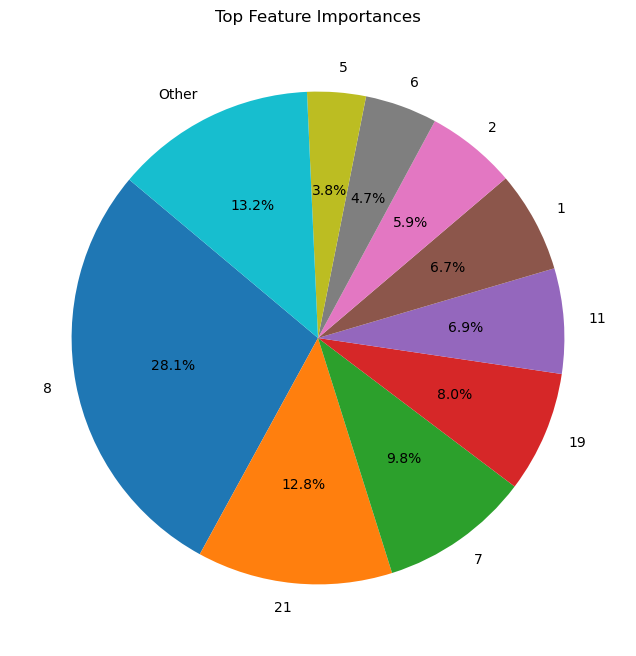

In [503]:
feature_importances = abs(coefficients)  # Take the absolute value of coefficients
sorted_idx = feature_importances.argsort()[::-1]  # Sort by importance

# Select the top N features for readability
N = 9  # Adjust N based on how many features you want to display
top_n_idx = sorted_idx[:N]
top_n_feature_names = [feature_names[i] for i in top_n_idx]
top_n_importances = feature_importances[top_n_idx]

# Additional 'Other' category for the rest
other_importance = sum(feature_importances) - sum(top_n_importances)
top_n_feature_names.append('Other')
top_n_importances = list(top_n_importances) + [other_importance]

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(top_n_importances, labels=top_n_feature_names, autopct='%1.1f%%', startangle=140)
plt.title('Top Feature Importances')
plt.show()

## Look at the rows that contain purchase in them and do some analysis on those

In [507]:
grouped_lists = pd.read_csv('GroupedLists.csv')

In [510]:
def activated(x):
    if 29 in x:
        return 1
    else:
        return 0

In [64]:
up_to_activation = pd.read_csv('up_to_activation.csv')

In [65]:
grouped_lists = up_to_activation.groupby('new_session')['ed_id'].apply(list).reset_index()

In [511]:
grouped_lists['activated'] = grouped_lists['ed_id'].apply(activated)

In [516]:
up_to_act

ed_id,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,27,28,29,activated
new_session,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5.0,1.0,1.0,66.0,6.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735763,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1735764,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1735765,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [515]:
grouped_lists

,new_session,ed_id,activated
0,1,"[12, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...",0
1,2,"[4, 4, 4, 4, 4, 2, 4, 4, 19, 19, 19, 19, 19, 3...",0
2,3,"[2, 12, 3, 19, 19, 19, 19, 19, 19, 19, 19, 19,...",0
3,4,"[19, 19, 19, 19, 19, 19, 3, 19, 12, 19, 19, 19...",0
4,5,"[12, 4, 4, 4, 4, 3, 19, 19, 19, 19, 19, 19, 19...",0
...,...,...,...
1713126,1735763,"[19, 19, 19, 19, 3, 19, 12, 1, 1, 1, 1]",0
1713127,1735764,"[12, 1, 1, 19, 19, 19, 19, 19, 19, 19, 19, 19, 3]",0
1713128,1735765,"[19, 19, 19, 19, 19, 19, 19, 19, 19, 3, 19, 19...",0
1713129,1735766,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


In [563]:
mask = up_to_act[8] == 1

In [564]:
mask.reset_index(drop=True, inplace=True)

In [565]:
downpayment_group = grouped_lists[mask]

In [566]:
percent_activated = round(sum(downpayment_group['activated'] == 1)/len(downpayment_group['activated']), 3) * 100

In [567]:
print(percent_activated,'% of those who made a purchase ended up activating')

99.8 % of those who made a purchase ended up activating


In [562]:
downpayment_group['ed_id']

10         [12, 1, 3, 3, 3, 3, 3, 3, 3, 19, 19, 19, 19, 1...
15         [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...
16         [19, 19, 19, 19, 19, 19, 19, 19, 19, 3, 19, 19...
22         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
27         [2, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19...
                                 ...                        
1713104                             [21, 12, 4, 4, 6, 5, 11]
1713111    [12, 1, 3, 19, 19, 19, 19, 19, 19, 19, 19, 19,...
1713113    [21, 12, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...
1713117    [12, 1, 3, 5, 6, 4, 4, 4, 4, 19, 19, 19, 19, 1...
1713130    [2, 19, 19, 19, 19, 3, 12, 19, 4, 4, 4, 4, 4, ...
Name: ed_id, Length: 286830, dtype: object

In [72]:
purchased_group

,new_session,ed_id,activated
13,14,"[2, 6, 19, 3, 19, 19, 19, 3, 19, 19, 19, 19, 1...",0
36,37,"[19, 19, 19, 19, 19, 3, 19, 19, 19, 3, 19, 3, ...",1
44,45,"[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...",1
46,47,"[2, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 3,...",1
47,48,"[19, 19, 19, 3, 19, 19, 19, 3, 19, 19, 19, 19,...",1
...,...,...,...
1735601,1735602,"[21, 12, 4, 11, 5, 6, 5, 5, 5, 4, 4, 4, 11, 4,...",1
1735712,1735713,"[21, 12, 1, 4, 4, 4, 4, 4, 4, 4, 6, 11, 11, 11...",1
1735721,1735722,"[21, 12, 1, 3, 3, 3, 19, 19, 19, 19, 19, 19, 1...",0
1735729,1735730,"[21, 2, 12, 19, 19, 19, 19, 19, 19, 19, 19, 19...",1


## How many activated accounts have a purchase?

In [506]:
activated_lists = grouped_lists[grouped_lists['activated'] == 1]

NameError: name 'grouped_lists' is not defined

In [100]:
len(activated_lists)

416441

In [93]:
activated_purchased_group = activated_lists[up_to_act['7'] == 1]

In [103]:
len(activated_purchased_group)

118870

In [106]:
activated_percent_purchased = round(((len(activated_purchased_group)/len(activated_lists)) * 100), 3)

In [108]:
print(activated_percent_purchased,'% of those who are activated already made a purchase')

28.544 % of those who are activated already made a purchase


### Markov Chain of Activated Accounts

In [568]:
import seaborn as sns

In [569]:
sessions_with_29 = up_to_activation[up_to_activation['ed_id'] == 29]['new_session'].unique()

# Keep only the rows in 'up_to_activation' where 'new_session' is in 'sessions_with_29'
up_to_activation_filtered = up_to_activation[up_to_activation['new_session'].isin(sessions_with_29)]

In [75]:
up_to_activation_filtered

,customer_id,account_id,ed_id,event_name,event_timestamp,journey_steps_until_end,new_session
350,-1257367741,1076891306,19,application_web_view,2023-01-04T17:41:54.000Z,1,12
351,-1257367741,1076891306,19,application_web_view,2023-01-04T17:41:56.000Z,2,12
352,-1257367741,1076891306,19,application_web_view,2023-01-04T17:41:57.000Z,3,12
353,-1257367741,1076891306,19,application_web_view,2023-01-04T17:43:00.000Z,4,12
354,-1257367741,1076891306,19,application_web_view,2023-01-04T17:43:00.000Z,5,12
...,...,...,...,...,...,...,...
56585945,-865005459,-983311387,5,view_cart,2021-05-13T21:33:23.000Z,36,1735767
56585946,-865005459,-983311387,6,begin_checkout,2021-05-13T21:34:09.000Z,37,1735767
56585947,-865005459,-983311387,8,place_downpayment,2021-05-13T21:40:05.000Z,38,1735767
56585948,-865005459,-983311387,7,place_order_web,2021-05-13T21:40:05.000Z,39,1735767


In [584]:
sessions = up_to_activation_filtered.groupby('new_session')['ed_id'].apply(list)

In [585]:
from collections import defaultdict

transition_counts = defaultdict(lambda: defaultdict(int))

In [586]:
for sequence in sessions:
    for i in range(len(sequence) - 1):
        current, next = sequence[i], sequence[i + 1]
        transition_counts[current][next] += 1

In [587]:
transition_matrix = defaultdict(lambda: defaultdict(float))

for current, next_states in transition_counts.items():
    total = sum(next_states.values())
    for next_state, count in next_states.items():
        transition_matrix[current][next_state] = count / total

In [588]:
transition_df = pd.DataFrame(transition_matrix).fillna(0).T

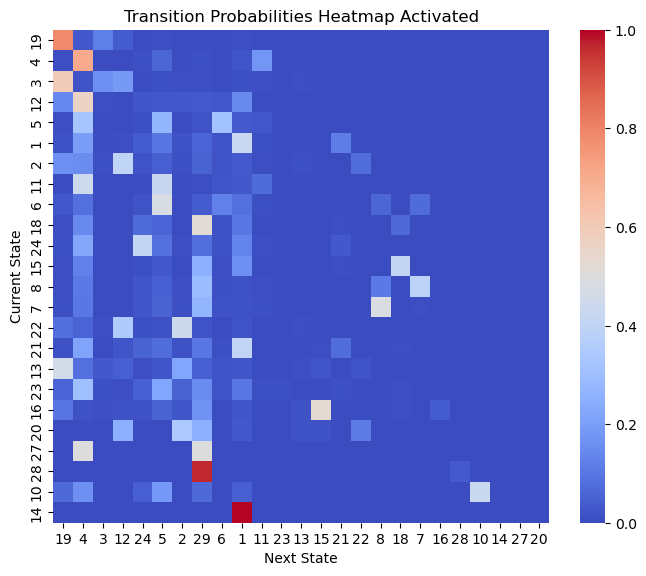

In [589]:
plt.figure(figsize=(8, 6.4))  # Adjust the figure size as necessary
sns.heatmap(transition_df, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Transition Probabilities Heatmap Activated')
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.show()

### Markov Chain of Un Activated Accounts

In [590]:
up_to_activation_unactivated = up_to_activation[~up_to_activation['new_session'].isin(sessions_with_29)]

In [591]:
sessions_unactivated = up_to_activation_unactivated.groupby('new_session')['ed_id'].apply(list)

In [592]:
from collections import defaultdict

transition_counts = defaultdict(lambda: defaultdict(int))

In [593]:
for sequence in sessions_unactivated:
    for i in range(len(sequence) - 1):
        current, next = sequence[i], sequence[i + 1]
        transition_counts[current][next] += 1

In [594]:
transition_matrix = defaultdict(lambda: defaultdict(float))

for current, next_states in transition_counts.items():
    total = sum(next_states.values())
    for next_state, count in next_states.items():
        transition_matrix[current][next_state] = count / total

In [600]:
transition_df = pd.DataFrame(transition_matrix).fillna(0).T

In [601]:
transition_df.loc['17'] = 0

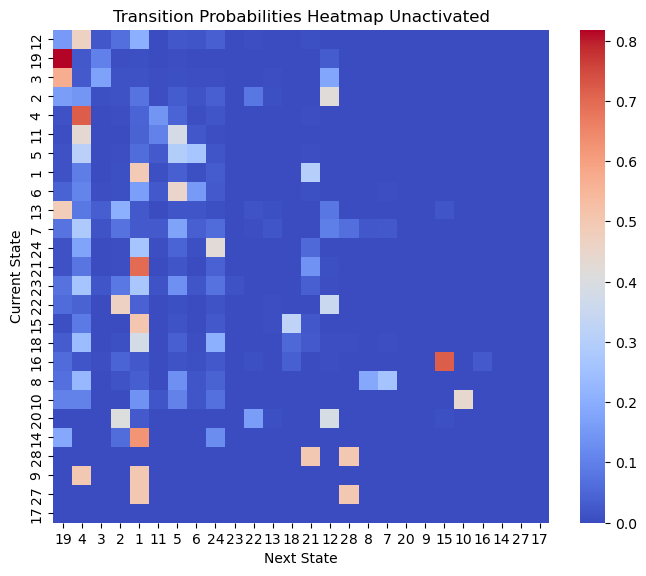

In [602]:
plt.figure(figsize=(8, 6.4))  # Adjust the figure size as necessary
sns.heatmap(transition_df, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Transition Probabilities Heatmap Unactivated')
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.show()

## Look at last 5 events in unactivated sessions

In [603]:
sessions_unactivated = up_to_activation_unactivated.groupby('new_session')['event_name'].apply(list)

In [604]:
last_five_elements = sessions_unactivated.apply(lambda x: x[-5:])

In [605]:
flattened_elements = [element for sublist in last_five_elements for element in sublist]
element_freq = pd.Series(flattened_elements).value_counts()

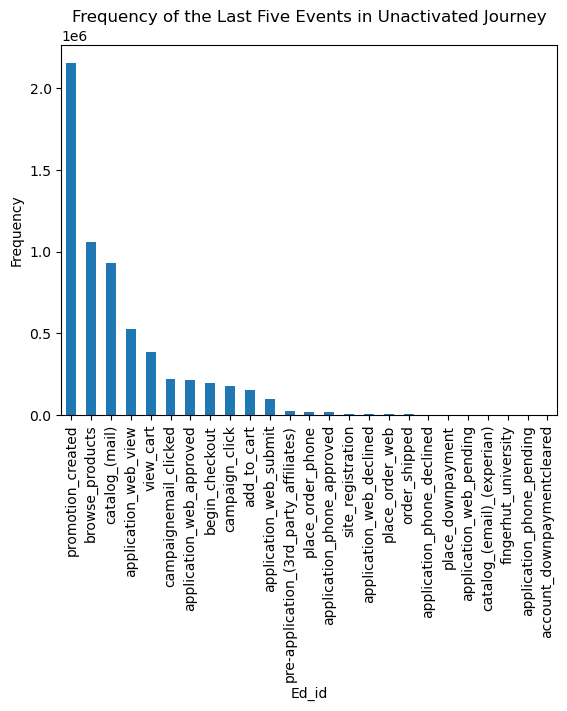

In [606]:
element_freq.plot(kind='bar')
plt.title('Frequency of the Last Five Events in Unactivated Journey')
plt.xlabel('Ed_id')
plt.ylabel('Frequency')
plt.show()

## Look at last 5 elements in activated journeys

In [607]:
sessions_with_29 = up_to_activation[up_to_activation['ed_id'] == 29]['new_session'].unique()

In [608]:
up_to_activation_filtered = up_to_activation[up_to_activation['new_session'].isin(sessions_with_29)]

In [609]:
sessions = up_to_activation_filtered.groupby('new_session')['event_name'].apply(list)

In [610]:
last_five_elements = sessions.apply(lambda x: x[-5:])

In [611]:
flattened_elements = [element for sublist in last_five_elements for element in sublist]
element_freq = pd.Series(flattened_elements).value_counts()

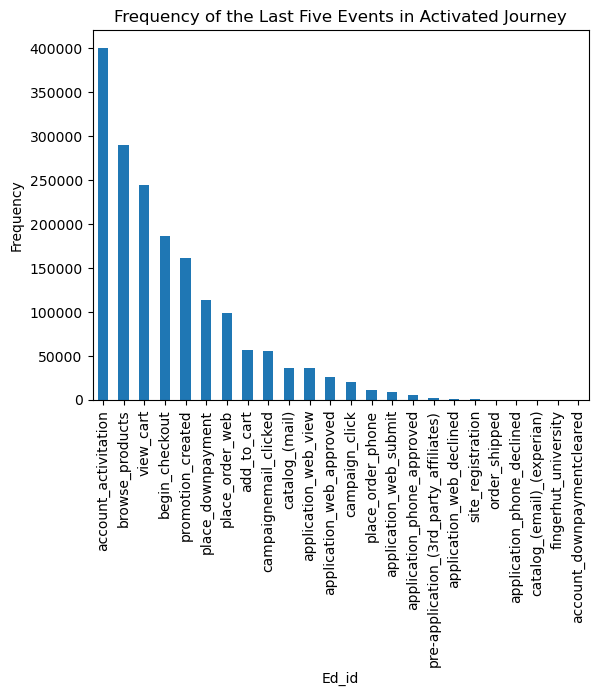

In [612]:
element_freq.plot(kind='bar')
plt.title('Frequency of the Last Five Events in Activated Journey')
plt.xlabel('Ed_id')
plt.ylabel('Frequency')
plt.show()